# Model 2

This Notebook contains the modeling of the prediction of a new ```overall review metric``` that reflects the overall consumer response of satisfaction. It contains the next structure:

* Uploaded Libraries, data set, variable declaration, and data split.
* Feature selection results (the GA rounds are in the notebook ```2_Genetic_algorithm_Airbnb_Model_2_not_cut.```)
* Training and Tuning process.
* Final model.
* Saving predictions for whole data set.


Notes: The model is required to use predicted price, description, and neighborhood_overview. Those were processed in the notebook ```01_Texthero_Text_processing```. 


1) Cleaned by removing: html tags, stop words, punctuation, digits, etc.
2) Represented by its TF-IDF (Term Frequency-Inverse Document Frequency).
3) Transformed into two components with PCA (Principal Component Analysis.

The transfomed features are:
* description_pca_x, description_pca_y.
* neighborhood_overview_pca_x, neighborhood_overview_pca_y.

## Libraries

In [1]:
%reload_ext autoreload
%autoreload 2

# visualisation and data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 200)


# system and files managment
import os
import sys
import pickle
import ast
import collections

# model splits
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

# model
import xgboost as xg

import warnings
warnings.filterwarnings('ignore')

In [2]:
# modules added to system path
path_tools = os.path.abspath(r'/Users/starignus/Documents/Programing/Practise_jobexam/FDA/Airbnb')
sys.path.extend([path_tools])

In [3]:
# exploring tools module
import tools.exploring_tools as mtool 
import tools.feature_selection as fselec
import tools.model_selection as mselec

## Paths

In [4]:
path_project = r'/Users/starignus/Documents/Programing/Practise_jobexam/FDA/'
path_input = os.path.join(path_project, 'Data', 'inputs')
path_ouput = os.path.join(path_project, 'Data', 'outputs')
listings = os.path.join(path_input, 'listings.csv')
# Data set with the new metric to be predicted and the predicte price from first model
data_set = os.path.join(path_input, 'extended_data_set_pred_01_GA_pca.pick')

## Upload Data

In [133]:
df = pd.read_pickle(data_set)

## Variable lists

The model is required to use predicted price, description, and neighborhood_overview. Also, it is included variables that reflect features of the host, location, availability, time with reviews.

In [131]:
var_all_considered = ['host_response_rate',
'host_acceptance_rate',
'host_is_superhost',
'latitude',
'longitude',
'accommodates',
'bedrooms',
'beds',
'has_availability',
'availability_30',
'availability_60',
'availability_90',
'availability_365',
'number_of_reviews',
'number_of_reviews_ltm',
'instant_bookable',
'reviews_per_month',
'room_type_num',
'months_since_first_reviews',
'months_with_reviews',
'months_as_host',
'predicted_price_log_01_GA', # predicted price from  model 1
'desccription_pca_x',
'desccription_pca_y',
'neighborhood_overview_pca_x',
'neighborhood_overview_pca_y',
'host_number_verifications',
'host_response_time_category']

In [132]:
len(var_all_considered)

28

### Variables for the model (GA and feature Importance)

From the notebook where the GA algorithm was run, the best varaibles found were:

In [31]:
list_var_GA = ['host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'latitude',
 'bedrooms',
 'has_availability',
 'availability_60',
 'availability_90',
 'number_of_reviews',
 'instant_bookable',
 'reviews_per_month',
 'months_since_first_reviews',
 'months_as_host',
 'predicted_price_log_01_GA',
 'neighborhood_overview_pca_x',
 'neighborhood_overview_pca_y',
 'desccription_pca_x',
 'desccription_pca_y',
 'host_number_verifications']

var_to_predict = 'overall_review_value'

In [148]:
len(list_var_GA)

19

## Evaluation Metric

In [25]:
def RMSE(y_true, y_pred):
    return np.sqrt(MSE(y_true, y_pred))

## Split data set 

In [134]:
y = df['overall_review_value'].values

In [135]:
X = df[var_all_considered].copy()

In [136]:
X.shape

(52534, 28)

In [137]:
X.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,latitude,longitude,accommodates,bedrooms,beds,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,instant_bookable,reviews_per_month,room_type_num,months_since_first_reviews,months_with_reviews,months_as_host,predicted_price_log_01_GA,desccription_pca_x,desccription_pca_y,neighborhood_overview_pca_x,neighborhood_overview_pca_y,host_number_verifications,host_response_time_category
0,100.0,90.0,0.0,51.46225,-0.11732,4,1.0,3.0,1.0,3,33,63,338,192,6,1.0,1.46,1,5.0,120.0,134.0,4.323723,-0.207060,-0.071857,0.115708,-0.066403,109,1.0
1,100.0,75.0,0.0,51.56802,-0.11121,2,1.0,0.0,1.0,30,60,90,365,21,1,0.0,0.17,2,9.0,114.0,133.0,3.916180,-0.156919,-0.140670,0.126038,-0.127408,93,2.0
2,NaN,100.0,0.0,51.48796,-0.16898,2,1.0,1.0,1.0,29,59,62,189,89,1,1.0,0.66,1,0.0,123.0,132.0,4.845178,-0.078360,-0.289400,-0.203779,0.033219,55,NaN
3,0.0,100.0,1.0,51.52195,-0.14094,6,3.0,3.0,1.0,16,16,16,231,42,0,0.0,0.35,1,14.0,104.0,131.0,5.372856,-0.065268,-0.359259,0.042830,-0.185334,123,4.0
5,NaN,100.0,1.0,51.57224,-0.20906,2,1.0,0.0,1.0,0,0,0,2,129,3,1.0,0.99,2,0.0,119.0,128.0,3.541085,0.140470,0.309092,-0.061274,-0.136107,100,NaN


In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

In [139]:
y_train

array([95. , 92.4, 70.5, ..., 90.4, 94.7, 90.4])

# Training model

Training with all the variables considered.

In [140]:
# Instantiation 
clf = xg.XGBRegressor(objective ='reg:squarederror', 
                      max_depth=3, 
                      n_estimators=100, 
                      random_state=0)

In [141]:
# set importance type to gain rather than default 'split'
clf.set_params(importance_type='gain')

XGBRegressor(objective='reg:squarederror')

In [142]:
clf.fit(X_train, y_train, verbose=True)

XGBRegressor(objective='reg:squarederror')

In [143]:
# Predict the model 
pred = clf.predict(X_test) 

In [144]:
# RMSE Computation 
rmse = np.sqrt(MSE(y_test, pred)) 
print("RMSE : % f" %(rmse))

RMSE :  8.600046


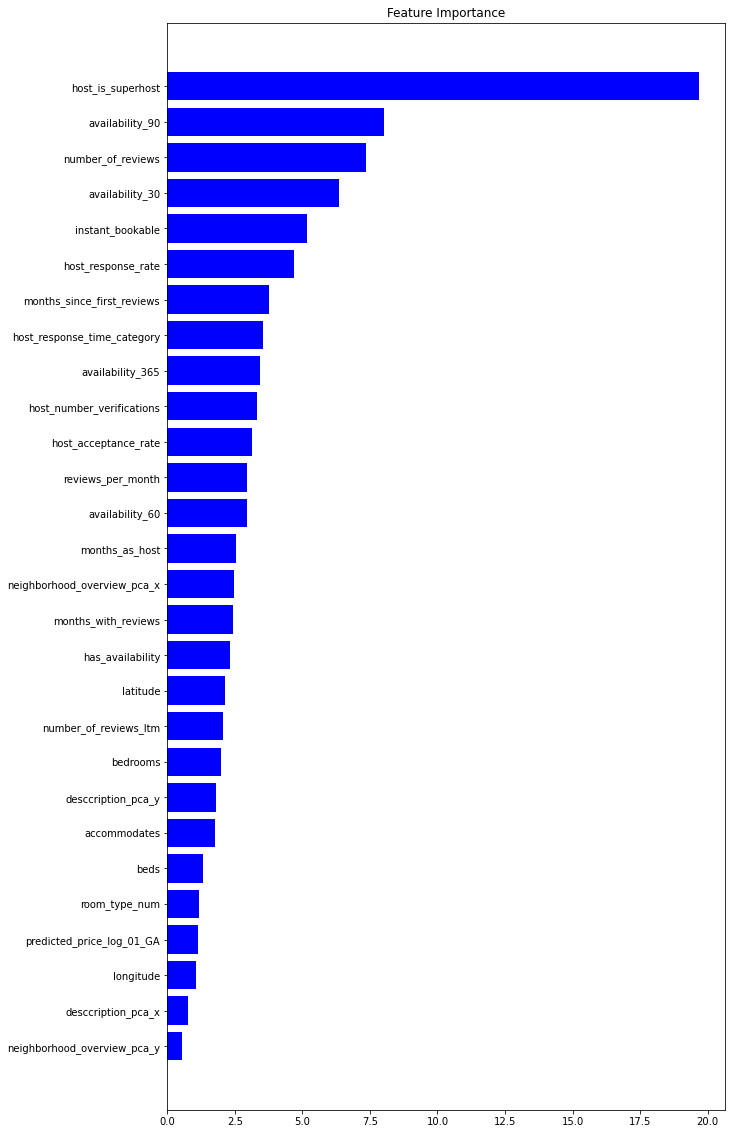

In [145]:
df_feat_import_1 = fselec.feature_importance(clf, model_type='Uncalibrated', feature_list=list(X_train.columns))

In [146]:
df_feat_import_1

,Feature_importance%
host_is_superhost,19.663939
availability_90,8.020429
number_of_reviews,7.372169
availability_30,6.373343
instant_bookable,5.184789
host_response_rate,4.689346
months_since_first_reviews,3.762942
host_response_time_category,3.550380
availability_365,3.440085
host_number_verifications,3.321156


## From GA results

Traing now a model with the best features from GA and feeature importance. The variable required were left in the model. 

In [17]:
clf_2 = xg.XGBRegressor(objective ='reg:squarederror', 
                        max_depth=3, 
                        n_estimators=100, 
                        random_state=0)

In [18]:
# set importance type to gain rather than default 'split'
clf_2.set_params(importance_type='gain')

XGBRegressor(objective='reg:squarederror')

In [19]:
eval_set_2 = [(X_train[list_var_GA], y_train), (X_test[list_var_GA], y_test)] 

In [20]:
clf_2.fit(X_train[list_var_GA], y_train, eval_set=eval_set_2)

[0]	validation_0-rmse:80.6858	validation_1-rmse:80.6021
[1]	validation_0-rmse:72.7168	validation_1-rmse:72.6343
[2]	validation_0-rmse:65.5514	validation_1-rmse:65.4751
[3]	validation_0-rmse:59.1165	validation_1-rmse:59.0441
[4]	validation_0-rmse:53.3364	validation_1-rmse:53.2672
[5]	validation_0-rmse:48.1474	validation_1-rmse:48.0846
[6]	validation_0-rmse:43.4918	validation_1-rmse:43.4355
[7]	validation_0-rmse:39.3186	validation_1-rmse:39.271
[8]	validation_0-rmse:35.5813	validation_1-rmse:35.5436
[9]	validation_0-rmse:32.2362	validation_1-rmse:32.2068
[10]	validation_0-rmse:29.2474	validation_1-rmse:29.2298
[11]	validation_0-rmse:26.5804	validation_1-rmse:26.5729
[12]	validation_0-rmse:24.2053	validation_1-rmse:24.213
[13]	validation_0-rmse:22.0936	validation_1-rmse:22.1154
[14]	validation_0-rmse:20.2223	validation_1-rmse:20.2614
[15]	validation_0-rmse:18.5676	validation_1-rmse:18.6217
[16]	validation_0-rmse:17.11	validation_1-rmse:17.1823
[17]	validation_0-rmse:15.83	validation_1-rms

XGBRegressor(objective='reg:squarederror')

In [21]:
X_train[list_var_GA].shape

(42027, 19)

In [22]:
X_test[list_var_GA].shape

(10507, 19)

In [23]:
# Predict the model 
pred_2 = clf_2.predict(X_test[list_var_GA]) 

In [26]:
# RMSE Computation 
rmse_2 = RMSE(y_test, pred_2) 
print("RMSE : % .4f" %(rmse_2))

RMSE :  8.6262


In [27]:
# retrieve performance metrics
results_2 = clf_2.evals_result()

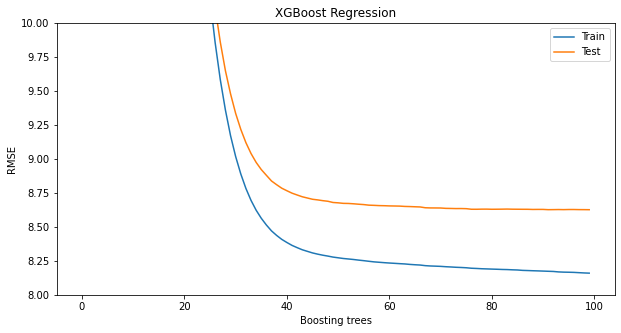

In [63]:
fselec.xgboost_learning_curve(results_2,y_lim=[8, 10])

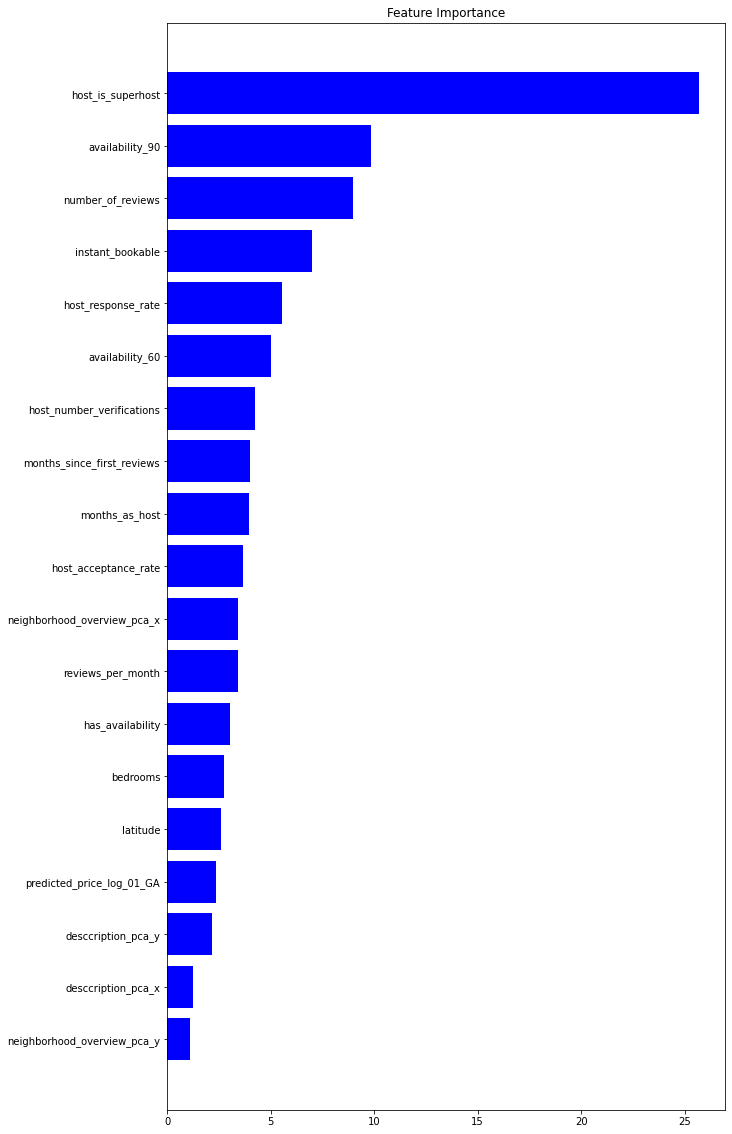

In [29]:
df_feat_import_2 = fselec.feature_importance(clf_2, model_type='Uncalibrated', feature_list=list_var_GA)

In [30]:
# We can still see from here 
df_feat_import_2

,Feature_importance%
host_is_superhost,25.673542
availability_90,9.822762
number_of_reviews,8.996095
instant_bookable,6.982974
host_response_rate,5.553941
availability_60,4.991377
host_number_verifications,4.252883
months_since_first_reviews,4.019692
months_as_host,3.929407
host_acceptance_rate,3.661424


In [32]:
corr_spear_2 = df[list_var_GA + [var_to_predict]].corr(method='spearman').abs()

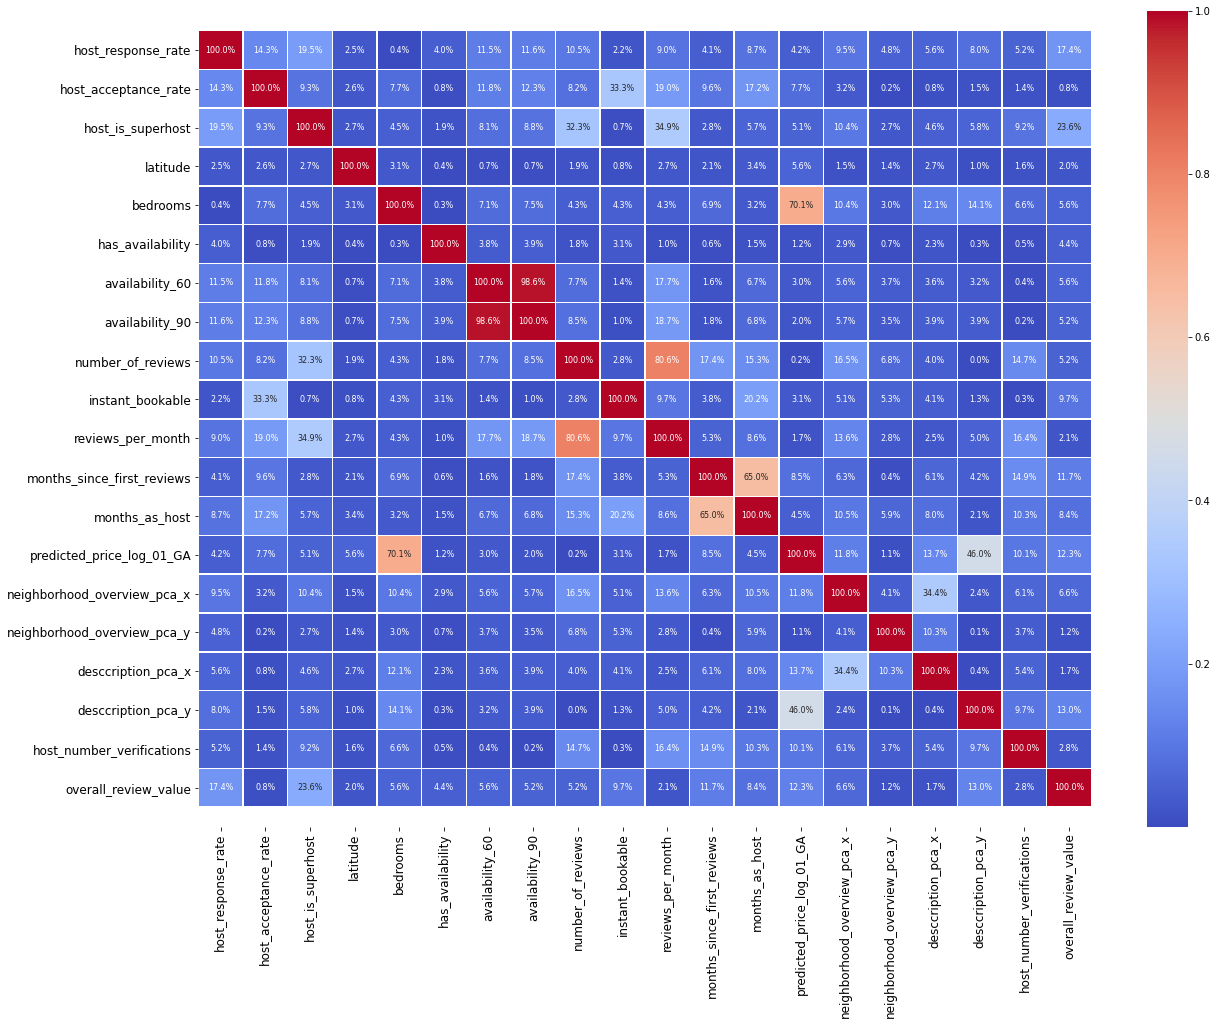

In [33]:
mtool.heat_map_corr(corr_spear_2, cmap='coolwarm', square=False, annot=True)

To quantfiy the imporvement in perfomrance in our different rounds, including the feature selection process and parameter tunning,a base line model will be biuld. To keep things simple the base line model predicts that the best price is the the mean value of our training set.

In [34]:
# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions_0 = np.ones(y_test.shape) * mean_train

In [35]:
# Compute RMSE
rmse_baseline = RMSE(y_test, baseline_predictions_0)
print("Baseline RMSE is {:.4f}".format(rmse_baseline))

Baseline RMSE is 9.2300


The model with the GA coming from our feature selection has a smaller error. 

In [36]:
# The performance of the XGB model has a 6% relative uplift w.r.t the base line 
print("Change in performance", rmse_2 - rmse_baseline)
print("Change in %", ((rmse_2 - rmse_baseline) / rmse_baseline) * 100)

Change in performance -0.6037990728339881
Change in % -6.5417358047187815


# Training and tunning

Some of the parameters of XGboost have different name as the ones used in skleanr. But since XGboost module in python has an sklearn wrapper it uses sklearn style naming convention too. The parameters names which will change are:

* ```eta``` –> ```learning_rate```
* ```lambda``` –> ```reg_lambda```
* ```alpha``` –> ```reg_alpha```


In sklern style we have as well ```n_estimators``` parameter in GBM. Well this exists as a parameter in XGBClassifier and XGBRegressor. Sometimes is called ```num_boosting_rounds```[(Ref 1)](https://xgboost.readthedocs.io/en/latest/python/python_api.html), [(Ref 2)](https://xgboost.readthedocs.io/en/latest/parameter.html).

In [37]:
# starting with parameters of the model with 14 variables
params = {
    # Parameters to tune.
    'max_depth':3,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'learnig_rate':0.1,
    'reg_lambda':1,
    # Other parameters
    'objective':'reg:squarederror',
    'random_state':0,
    'eval_metric': 'rmse',
    'importance_type':'gain'
}

Before tunning the parameters in the dictionary, first I will look how to get the number of boosters or estimators to build. ```n_estimators``` is the same ```num_boost_round```. Its optimal value highly depends on the other parameters, and thus it should be re-tuned each time you update a parameter. You could do this by tuning it together with all parameters in a grid-search, but it requires a lot of computational effort.

Tehrefore, it can be used the method of XGBoost that provides a good way to find the best number of estimators whilst training. In XGboost, the trees are built sequentially instead of fixing the number of rounds at the beginning, the model can be test at each step and see if adding a new tree/round improves performance.

```num_boost_round``` are the maximum number of trees or boosting rounds that will be allowed. So it can be set to a large number hoping to find the optimal number before reaching it. If we find it has not improved the performance on the test set, it can be used the ```early_stopping_round rounds``` to stop the training and keep the best number of boosting rounds. If we set up to 10, it means that from a current point of evaluation, it will continue 10 more times and asses if there is still significative improvement by addding more trees. If that is not the case, when ending the 10 round it will stop.

Here I explore first how it will be used to train the model once the parameters are tuned, so the best numbers of rounds or booster are found.

In [38]:
num_boost_round = 999

In [39]:
dtrain = xg.DMatrix(X_train[list_var_GA], label=y_train)
dtest = xg.DMatrix(X_test[list_var_GA], label=y_test)

In [40]:
model_0 = xg.train(params,
                    dtrain,
                    num_boost_round=num_boost_round,
                    evals=[(dtest, "Test")],
                    early_stopping_rounds=10)

[0]	Test-rmse:62.9166
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:44.4662
[2]	Test-rmse:31.7261
[3]	Test-rmse:23.0484
[4]	Test-rmse:17.2876
[5]	Test-rmse:13.5993
[6]	Test-rmse:11.3791
[7]	Test-rmse:10.1057
[8]	Test-rmse:9.40816
[9]	Test-rmse:9.04942
[10]	Test-rmse:8.87629
[11]	Test-rmse:8.77855
[12]	Test-rmse:8.73185
[13]	Test-rmse:8.70652
[14]	Test-rmse:8.69438
[15]	Test-rmse:8.68564
[16]	Test-rmse:8.68207
[17]	Test-rmse:8.65911
[18]	Test-rmse:8.65506
[19]	Test-rmse:8.6509
[20]	Test-rmse:8.64751
[21]	Test-rmse:8.64314
[22]	Test-rmse:8.64084
[23]	Test-rmse:8.63423
[24]	Test-rmse:8.62909
[25]	Test-rmse:8.62627
[26]	Test-rmse:8.62584
[27]	Test-rmse:8.62318
[28]	Test-rmse:8.62131
[29]	Test-rmse:8.62183
[30]	Test-rmse:8.62216
[31]	Test-rmse:8.62194
[32]	Test-rmse:8.62247
[33]	Test-rmse:8.61685
[34]	Test-rmse:8.61595
[35]	Test-rmse:8.61608
[36]	Test-rmse:8.61707
[37]	Test-rmse:8.61807
[38]	Test-rmse:8.62036
[39]	Test-rmse:8.62159
[40]	Test-rmse:8.62112
[41]	Test-r

In [41]:
print("Best RMSE: {:.4f} with {} rounds".format(
                 model_0.best_score,
                 model_0.best_iteration + 1))

Best RMSE: 8.6159 with 35 rounds


In [42]:
### If early stop happens
model_0.best_ntree_limit

35

The model with the defined parameters was trained with more rounds than optimal, and the RMSE is about 0.3991

```ntree_limit```is an integer number that limits the number of trees in the prediction; defaults to ```best_ntree_limit``` if defined (i.e. it has been trained with early stopping), otherwise 0 (use all trees).

In [43]:
# model prediction given the trees it was trained on
pred_model_0 = model_0.predict(dtest, ntree_limit=model_0.best_ntree_limit) 
pred_model_0

array([88.63312 , 84.98031 , 79.2354  , ..., 81.538376, 92.46199 ,
       91.90815 ], dtype=float32)

In [44]:
# Compute RMSE
rmse_untuned = RMSE(y_test, pred_model_0)
print("RMSE is {:.4f}".format(rmse_untuned))

RMSE is 8.6159


In [45]:
# If we do not provide the best_ntree_limit it will use all the trees
pred_model_0_f = model_0.predict(dtest) 
pred_model_0_f

array([88.54794 , 85.065254, 79.200966, ..., 81.64159 , 92.52591 ,
       91.74522 ], dtype=float32)

In [46]:
# Compute RMSE
rmse_untuned_f = RMSE(y_test, pred_model_0_f)
print("RMSE is {:.4f}".format(rmse_untuned_f))

RMSE is 8.6254


In [47]:
cv_results_0 = xg.cv(params, 
                      dtrain,
                      num_boost_round=num_boost_round,
                      seed=42,
                      nfold=5,
                      metrics={'rmse'},
                      early_stopping_rounds=10)

In [48]:
cv_results_0.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,62.993146,0.011453,62.995660,0.090718
1,44.519732,0.003395,44.525948,0.080285
2,31.753268,0.008140,31.761070,0.062397
3,23.037735,0.016774,23.052677,0.040393
4,17.217413,0.025735,17.239322,0.040078


In [49]:
cv_results_0.shape

(29, 4)

In [50]:
cv_results_0['test-rmse-mean'].argmin()

28

train-rmse-mean 8.1560068
test-rmse-mean 8.353543
train-rmse-std 0.003394557373208327
test-rmse-std 0.040077921346297625


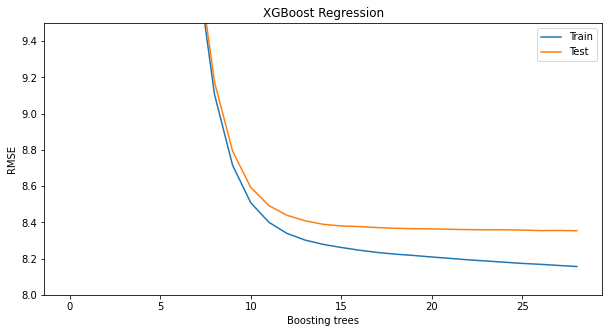

In [60]:
fselec.xgboost_learning_curve(cv_results_0, 
                              train_label='train-rmse-mean',
                              test_label='test-rmse-mean',
                              std_col=['train-rmse-std', 'test-rmse-std'],
                              y_lim=[8, 9.5]
                             )

With the current parameters we can see that as the number of bossters increases the variance or overfit occures since the corss validation error gets larger than the training error. So having fewer trees, leads to higher bias or underfittin. That is that the cross validating error is aproximatley equal to the training error.

If we were having infinite resources and not time constrains, a full grid search could be run with all the parameters together and find the optimal solution. It requires a lot of computational effort and we could find one model that could be closer to that optimal one that gives enough performance for our porpouse.

## Tuning the parameters that constraint the architecture or complexity of the trees: 
* ```max_depth``` is the maximum number of nodes allowed from the root to the last leaf of a tree. The deeper a tree is, the more it can model more complex relationships by adding more nodes. But if we go deeper, the splits become less relevant and are sometimes only due to noise, causing the model to overfit.

* ```min_child_weight``` is the number of samples (if all samples have a weight=1) required so it can be created a new node in the tree. When ```min_child_weight``` is small, it allows the algorithm to create children that correspond to fewer samples, thus allowing for more complex trees, but again, more likely to overfit (the children are learnig from few examples, therefore overfits).

Therefore, it is important to tune them together in order to find a good trade-off between model bias and variance
The following list contains all the combinations of both parameters to try.

In [64]:
gridsearch_params_complx = [(max_depth, min_child_weight) 
                            for max_depth in range(2,6)
                            for min_child_weight in range(1,7)]

In [65]:
len(gridsearch_params_complx)

24

In [66]:
min_test_err, min_train_err, boost_rounds = mselec.grid_search(gridsearch_params=gridsearch_params_complx,
                                                                orignal_params=params,
                                                                param_list_name=['max_depth', 'min_child_weight'],
                                                                dtrain=dtrain,
                                                                num_boost_round=num_boost_round,
                                                                seed=42,
                                                                nfold=5,
                                                                metrics={'rmse'},
                                                                early_stopping_rounds=10)

CV for max_depth=2 and min_child_weight=1
\RMSE 8.3775398 for 44 rounds
CV for max_depth=2 and min_child_weight=2
\RMSE 8.3669586 for 58 rounds
CV for max_depth=2 and min_child_weight=3
\RMSE 8.371609799999998 for 52 rounds
CV for max_depth=2 and min_child_weight=4
\RMSE 8.363371400000002 for 69 rounds
CV for max_depth=2 and min_child_weight=5
\RMSE 8.366883999999999 for 70 rounds
CV for max_depth=2 and min_child_weight=6
\RMSE 8.3583274 for 86 rounds
CV for max_depth=3 and min_child_weight=1
\RMSE 8.353543 for 29 rounds
CV for max_depth=3 and min_child_weight=2
\RMSE 8.354997800000001 for 27 rounds
CV for max_depth=3 and min_child_weight=3
\RMSE 8.3518584 for 47 rounds
CV for max_depth=3 and min_child_weight=4
\RMSE 8.3578444 for 38 rounds
CV for max_depth=3 and min_child_weight=5
\RMSE 8.350658399999999 for 37 rounds
CV for max_depth=3 and min_child_weight=6
\RMSE 8.352981199999999 for 50 rounds
CV for max_depth=4 and min_child_weight=1
\RMSE 8.3335968 for 24 rounds
CV for max_depth=

44 minutes execution time

We get the best score with a max_depth of 5 and min_child_weight of 6, so let's update the params

In [67]:
# updating the dicitonary with the optimal values found 
params['max_depth'] = 4
params['min_child_weight'] = 6

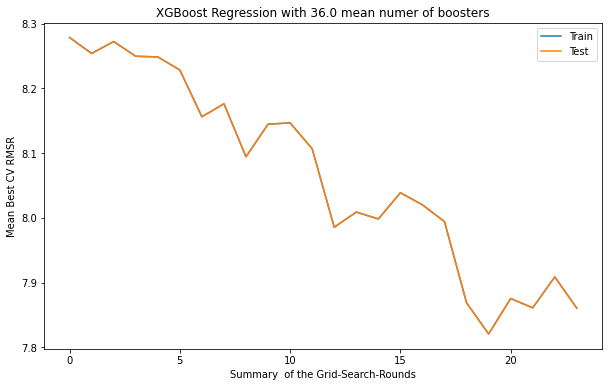

In [68]:
# I my remove this, I am just checking 
mselec.grid_search_rounds(min_test_err, min_train_err, boost_rounds, y_limit=None)

## Tuning the parameters that control the sampling of the data set at each boosting round. 

What they do is that instead of allowing the whole data set to be used at every round, it builds a tree on slightly different data at each step. This approach is followed since it makes it less likely to overfit to a single sample or feature.

* ```subsample``` is the fraction of observations or rows to subsample at each step.The default is set to 1 meaning that is using the whole observations or rows.

* ```colsample_bytree``` is fraction of features/variables/columns to be used. The default is set to 1 meaning that is using all features.


In [69]:
gridsearch_params = [(subsample, colsample)
                    for subsample in [i/10. for i in range(5,11)]
                    for colsample in [i/10. for i in range(5,11)]
                    ]

In [70]:
len(gridsearch_params)

36

In [71]:
min_test_err_2, min_train_err_2, boost_rounds_2 = mselec.grid_search(gridsearch_params=gridsearch_params,
                                                                orignal_params=params,
                                                                param_list_name=['subsample', 'colsample_bytree'],
                                                                dtrain=dtrain,
                                                                num_boost_round=num_boost_round,
                                                                seed=42,
                                                                nfold=5,
                                                                metrics={'rmse'},
                                                                early_stopping_rounds=10)

CV for subsample=0.5 and colsample_bytree=0.5
\RMSE 8.383105200000001 for 24 rounds
CV for subsample=0.5 and colsample_bytree=0.6
\RMSE 8.3920778 for 22 rounds
CV for subsample=0.5 and colsample_bytree=0.7
\RMSE 8.3907508 for 20 rounds
CV for subsample=0.5 and colsample_bytree=0.8
\RMSE 8.3802204 for 17 rounds
CV for subsample=0.5 and colsample_bytree=0.9
\RMSE 8.396671999999999 for 18 rounds
CV for subsample=0.5 and colsample_bytree=1.0
\RMSE 8.3959096 for 18 rounds
CV for subsample=0.6 and colsample_bytree=0.5
\RMSE 8.382763399999998 for 20 rounds
CV for subsample=0.6 and colsample_bytree=0.6
\RMSE 8.37922 for 24 rounds
CV for subsample=0.6 and colsample_bytree=0.7
\RMSE 8.3865554 for 21 rounds
CV for subsample=0.6 and colsample_bytree=0.8
\RMSE 8.3780822 for 17 rounds
CV for subsample=0.6 and colsample_bytree=0.9
\RMSE 8.3817984 for 23 rounds
CV for subsample=0.6 and colsample_bytree=1.0
\RMSE 8.3830702 for 26 rounds
CV for subsample=0.7 and colsample_bytree=0.5
\RMSE 8.3621854 for 

We get the best parameters are subsample = 1.0, colsample_bytree = 1.0, so let's update the params.

In [72]:
params['subsample'] = 1.0
params['colsample_bytree'] = 1.0

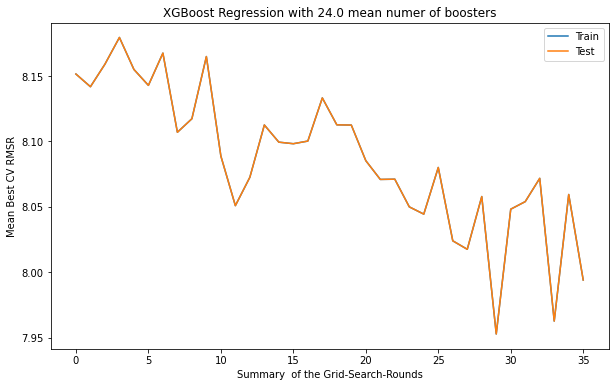

In [73]:
# I my remove this, I am just checking the path of the search
mselec.grid_search_rounds(min_test_err_2, min_train_err_2, boost_rounds_2, y_limit=None)

## Tuning the parameters that controls the learning and model regularisation

* ```eta``` alias ```learning_rate``` controls the shrinkage of the weights associated to features after each round, in other words it defines the amount of "correction" we make at each step. Remeber that that at each boosting round is correcting the errors of previous rounds. So having a small value of this parameter makes our model more robust to everfitting, so the smaller it is the most conservative it becomes. But the price to pay is to to increase the number of boosting rounds which takes more time to train, and sometimes without achiving great improvements.

* ```reg_lambda```L2 regularization term on weights. Increasing this value will make model more conservative to avoid overfitting.

In [77]:
learning_rate_val = [.2, .1, .05, .01, .005]

In [78]:
reag_lambda_val = [1e-5, 1e-2, 0.1, 1, 20, 80, 120]

In [79]:
gridsearch_params = [(learning_rate, reg_lambda)
                    for learning_rate in learning_rate_val
                    for reg_lambda in reag_lambda_val
                    ]

In [80]:
len(gridsearch_params)

35

In [81]:
min_test_err_3, min_train_err_3, boost_rounds_3 = mselec.grid_search(gridsearch_params=gridsearch_params,
                                                                orignal_params=params,
                                                                param_list_name=['learning_rate', 'reg_lambda'],
                                                                dtrain=dtrain,
                                                                num_boost_round=num_boost_round,
                                                                seed=42,
                                                                nfold=5,
                                                                metrics={'rmse'},
                                                                early_stopping_rounds=10)

CV for learning_rate=0.2 and reg_lambda=1e-05
\RMSE 8.32381 for 32 rounds
CV for learning_rate=0.2 and reg_lambda=0.01
\RMSE 8.3219892 for 38 rounds
CV for learning_rate=0.2 and reg_lambda=0.1
\RMSE 8.327109399999998 for 34 rounds
CV for learning_rate=0.2 and reg_lambda=1
\RMSE 8.321111400000001 for 43 rounds
CV for learning_rate=0.2 and reg_lambda=20
\RMSE 8.3164682 for 43 rounds
CV for learning_rate=0.2 and reg_lambda=80
\RMSE 8.3148716 for 69 rounds
CV for learning_rate=0.2 and reg_lambda=120
\RMSE 8.3162792 for 62 rounds
CV for learning_rate=0.1 and reg_lambda=1e-05
\RMSE 8.309088200000001 for 94 rounds
CV for learning_rate=0.1 and reg_lambda=0.01
\RMSE 8.308441 for 89 rounds
CV for learning_rate=0.1 and reg_lambda=0.1
\RMSE 8.313497800000002 for 84 rounds
CV for learning_rate=0.1 and reg_lambda=1
\RMSE 8.309262999999998 for 109 rounds
CV for learning_rate=0.1 and reg_lambda=20
\RMSE 8.3017418 for 146 rounds
CV for learning_rate=0.1 and reg_lambda=80
\RMSE 8.3125412 for 184 rounds


In [158]:
params['learning_rate'] = 0.05
params['reg_lambda'] = 20

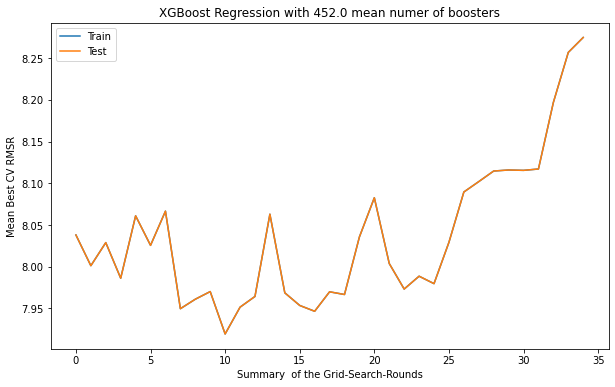

In [83]:
# I my remove this, I am just checking the path of the search
mselec.grid_search_rounds(min_test_err_3, min_train_err_3, boost_rounds_3, y_limit=None)

In [160]:
params_final = {'max_depth': 4,
                 'min_child_weight': 6,
                 'subsample': 1.0,
                 'colsample_bytree': 1.0,
                 'reg_lambda': 20,
                 'objective': 'reg:squarederror',
                 'random_state': 0,
                 'eval_metric': 'rmse',
                 'importance_type': 'gain',
                 'learning_rate': 0.05}

## Training  the model

Finding the optimal  value of ```num_boost_round optimal``` highly depends on the other parameters, and thus it should be re-tuned each time you update a parameter. In the CV we did something similar for finding the best other parameters, but now that we have the final set, it is the turn to find the optimal number of boosters. Let's see how much we improve our base line score, and the one from the untune model.

In [162]:
model_1 = xg.train(params_final,
                    dtrain,
                    num_boost_round=num_boost_round,
                    evals=[(dtest, "Test")],
                    early_stopping_rounds=10)

[0]	Test-rmse:85.0384
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:80.8338
[2]	Test-rmse:76.8428
[3]	Test-rmse:73.0513
[4]	Test-rmse:69.4562
[5]	Test-rmse:66.0401
[6]	Test-rmse:62.7996
[7]	Test-rmse:59.7228
[8]	Test-rmse:56.8041
[9]	Test-rmse:54.0332
[10]	Test-rmse:51.4066
[11]	Test-rmse:48.9132
[12]	Test-rmse:46.5504
[13]	Test-rmse:44.3087
[14]	Test-rmse:42.1831
[15]	Test-rmse:40.1683
[16]	Test-rmse:38.2597
[17]	Test-rmse:36.451
[18]	Test-rmse:34.7366
[19]	Test-rmse:33.1143
[20]	Test-rmse:31.5792
[21]	Test-rmse:30.1253
[22]	Test-rmse:28.75
[23]	Test-rmse:27.451
[24]	Test-rmse:26.2209
[25]	Test-rmse:25.0596
[26]	Test-rmse:23.9633
[27]	Test-rmse:22.9281
[28]	Test-rmse:21.952
[29]	Test-rmse:21.0339
[30]	Test-rmse:20.1678
[31]	Test-rmse:19.3522
[32]	Test-rmse:18.5872
[33]	Test-rmse:17.8669
[34]	Test-rmse:17.1897
[35]	Test-rmse:16.5558
[36]	Test-rmse:15.9626
[37]	Test-rmse:15.4061
[38]	Test-rmse:14.886
[39]	Test-rmse:14.4006
[40]	Test-rmse:13.9469
[41]	Test-rmse:1

In [166]:
print("Best RMSE: {:.4f} with {} rounds".format(
                 model_1.best_score,
                 model_1.best_iteration + 1))

Best RMSE: 8.5748 with 234 rounds


In [167]:
# If early stop happens
model_1.best_ntree_limit

234

```ntree_limit```is an integer number that limits the number of trees in the prediction; defaults to ```best_ntree_limit``` if defined (i.e. it has been trained with early stopping), otherwise 0 (use all trees).

In [168]:
# model prediction given the trees it was trained on
pred_model_1 = model_1.predict(dtest, ntree_limit=model_1.best_ntree_limit) 
pred_model_1

array([88.82621, 85.84186, 78.1075 , ..., 87.21129, 92.2968 , 91.62172],
      dtype=float32)

In [169]:
# Compute v
rmse_tuned = RMSE(y_test, pred_model_1)
print("Tuned before num_boost_dound and limit the trees for early stop RMSE is {:.4f}".format(rmse_tuned))

Tuned before num_boost_dound and limit the trees for early stop RMSE is 8.5748


In [170]:
# If we do not provide the best_ntree_limit it will use all the trees
pred_model_1_f = model_0.predict(dtest) 
pred_model_1_f

array([88.54794 , 85.065254, 79.200966, ..., 81.64159 , 92.52591 ,
       91.74522 ], dtype=float32)

In [171]:
# Compute RMSE
rmse_tuned_f = RMSE(y_test, pred_model_1_f)
print("Tuned before num_boost_dound and full trees RMSE is {:.4f}".format(rmse_tuned_f))

Tuned before num_boost_dound and full trees RMSE is 8.6254


In [172]:
cv_results_f = xg.cv(params_final, 
                      dtrain,
                      num_boost_round=num_boost_round,
                      seed=42,
                      nfold=5,
                      metrics={'rmse'},
                      early_stopping_rounds=10)

In [173]:
cv_results_f.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,85.129619,0.019424,85.126147,0.092496
1,80.916627,0.018929,80.920721,0.092142
2,76.923178,0.018967,76.928516,0.092789
3,73.135362,0.017442,73.137103,0.091569
4,69.539517,0.013788,69.538329,0.091126


In [174]:
cv_results_f.shape

(234, 4)

In [175]:
cv_results_f['test-rmse-mean'].argmin()

232

train-rmse-mean 7.99671
test-rmse-mean 8.3015374
train-rmse-std 0.002512448017374782
test-rmse-std 0.03424285805478289


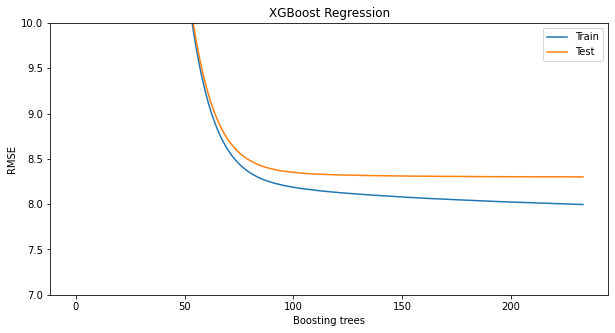

In [176]:
fselec.xgboost_learning_curve(cv_results_f, 
                              train_label='train-rmse-mean',
                              test_label='test-rmse-mean',
                              std_col=['train-rmse-std', 'test-rmse-std'],
                              y_lim=[7, 10]
                             )

Although it was found the best number of rounds, as we mentioned before, it has been trained with more rounds than optimal. Therefore, before using it for predictions, it should be retrained with the good number of rounds. Since ```best num_boost_round``` was found, there is no need the early_stopping_round anymore.

In [177]:
num_boost_round = model_1.best_iteration + 1
num_boost_round

234

In [178]:
model_final = xg.train(params_final,
                       dtrain,
                       num_boost_round=num_boost_round,
                       evals=[(dtest, "Test")])

[0]	Test-rmse:85.0384
[1]	Test-rmse:80.8338
[2]	Test-rmse:76.8428
[3]	Test-rmse:73.0513
[4]	Test-rmse:69.4562
[5]	Test-rmse:66.0401
[6]	Test-rmse:62.7996
[7]	Test-rmse:59.7228
[8]	Test-rmse:56.8041
[9]	Test-rmse:54.0332
[10]	Test-rmse:51.4066
[11]	Test-rmse:48.9132
[12]	Test-rmse:46.5504
[13]	Test-rmse:44.3087
[14]	Test-rmse:42.1831
[15]	Test-rmse:40.1683
[16]	Test-rmse:38.2597
[17]	Test-rmse:36.451
[18]	Test-rmse:34.7366
[19]	Test-rmse:33.1143
[20]	Test-rmse:31.5792
[21]	Test-rmse:30.1253
[22]	Test-rmse:28.75
[23]	Test-rmse:27.451
[24]	Test-rmse:26.2209
[25]	Test-rmse:25.0596
[26]	Test-rmse:23.9633
[27]	Test-rmse:22.9281
[28]	Test-rmse:21.952
[29]	Test-rmse:21.0339
[30]	Test-rmse:20.1678
[31]	Test-rmse:19.3522
[32]	Test-rmse:18.5872
[33]	Test-rmse:17.8669
[34]	Test-rmse:17.1897
[35]	Test-rmse:16.5558
[36]	Test-rmse:15.9626
[37]	Test-rmse:15.4061
[38]	Test-rmse:14.886
[39]	Test-rmse:14.4006
[40]	Test-rmse:13.9469
[41]	Test-rmse:13.5238
[42]	Test-rmse:13.1314
[43]	Test-rmse:12.7654
[44]

In [179]:
# If we do not provide the best_ntree_limit it will use all the trees
pred_model_f_f = model_final.predict(dtest) 
pred_model_f_f

array([88.82621, 85.84186, 78.1075 , ..., 87.21129, 92.2968 , 91.62172],
      dtype=float32)

In [180]:
# Compute RMSE
rmse_tuned_f_f = RMSE(y_test, pred_model_f_f)
print("Final RMSE is {:.4f}".format(rmse_tuned_f_f))

Final RMSE is 8.5748


In [181]:
model_final.save_model("overall_review_score_model_fina_GA_FS.model")

In [182]:
# The performance of the model without tunig is lower
# We gain by tuning a 0.6% relative uplift
print("Change in performance", rmse_tuned_f_f - rmse_2)
print("Change in %", ((rmse_tuned_f_f - rmse_2) / rmse_2) * 100)

Change in performance -0.051318112212294764
Change in % -0.5949130837250743


In [183]:
# The performance of the XGB model has a 7% relative uplift w.r.t the base line 
print("Change in performance", rmse_tuned_f_f - rmse_baseline)
print("Change in %", ((rmse_tuned_f_f - rmse_baseline) / rmse_baseline) * 100)

Change in performance -0.6551171850462829
Change in % -7.0977312462388555


Getting final model featuer importance

In [187]:
# Instance with final parameters to get the feature feature importance 
clf_f_f = xg.XGBRegressor(objective ='reg:squarederror', 
                      max_depth=4, 
                      n_estimators=234,
                      min_child_weight=6,
                      subsample=1.0,
                      colsample_bytree=1.0,
                      learning_rate=0.1,
                      reg_lambda=20,
                      eval_metric='rmse',
                      random_state=0)

In [188]:
# set importance type to gain rather than default 'split'
clf_f_f.set_params(importance_type='gain')

XGBRegressor(colsample_bytree=1.0, eval_metric='rmse', max_depth=4,
             min_child_weight=6, n_estimators=234, objective='reg:squarederror',
             reg_lambda=20, subsample=1.0)

In [191]:
clf_f_f.fit(X_train[list_var_GA], y_train)

XGBRegressor(colsample_bytree=1.0, eval_metric='rmse', max_depth=4,
             min_child_weight=6, n_estimators=234, objective='reg:squarederror',
             reg_lambda=20, subsample=1.0)

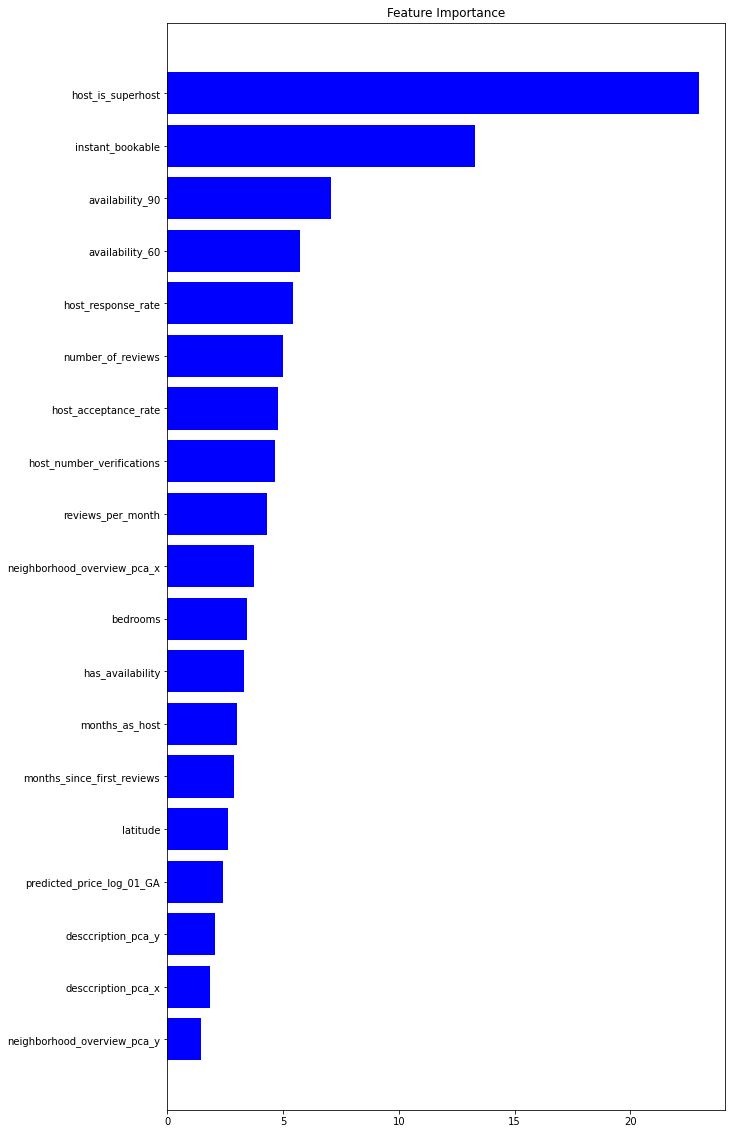

In [192]:
df_feat_import_f_f = fselec.feature_importance(clf_f_f, model_type='Uncalibrated', feature_list=list_var_GA)

In [193]:
df_feat_import_f_f

,Feature_importance%
host_is_superhost,22.950920
instant_bookable,13.276325
availability_90,7.056178
availability_60,5.736556
host_response_rate,5.422876
number_of_reviews,5.005566
host_acceptance_rate,4.782241
host_number_verifications,4.637665
reviews_per_month,4.319179
neighborhood_overview_pca_x,3.730767


# Prediction price for th whole data set

In [112]:
# Predict all the preices in the data set
all_data = xg.DMatrix(df[list_var_GA])

In [113]:
pred_model_all = model_final.predict(all_data) 

In [114]:
# Price is in log scale so we need to convert it back
df_c = df.copy()

In [115]:
df_c['predicted_overall_review_value'] = pred_model_all

In [120]:
mtool.stats_summary(df_c[['overall_review_value', 'predicted_overall_review_value']]).T

,overall_review_value,predicted_overall_review_value
count,52534.000000,52534.000000
mean,89.584568,89.618629
std,9.001203,3.216149
min,2.000000,56.790398
25%,87.900000,88.125374
50%,92.000000,90.054092
75%,94.900000,91.692818
max,95.000000,95.774910
median,92.000000,90.054092
skew,-4.363099,-1.603783


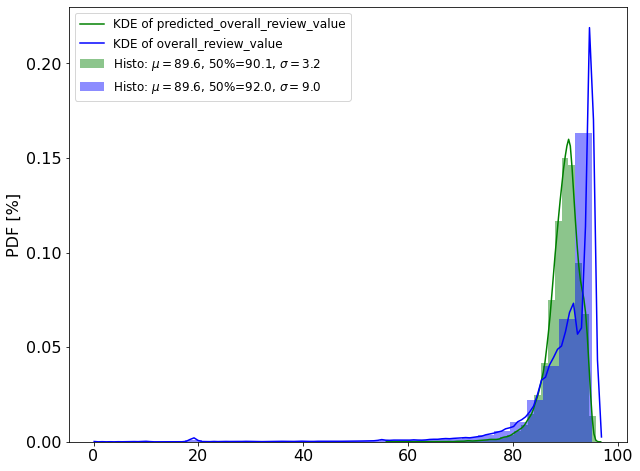

In [118]:
fig, ax = plt.subplots(figsize=(10,8))
mtool.plotting_one_kde(df_c, 'predicted_overall_review_value', ax=ax, color='g')
mtool.plotting_one_kde(df_c, 'overall_review_value', ax=ax, color='b')
None

* The *predicted_overall_review_value* is less skewed and with a smaller kurtosis (smaller pick) than the *overall_review_value*. The dispersio of the predicted review score also is smaller.

In [121]:
# df_c.to_pickle(os.path.join(path_input, 'extended_data_set_pred_model_02_GA_FS.pick'))